In [1]:
import yaml
import torch
import torch.nn.functional as F
import nets.gen_net
from data_processing.dilated_patcher import dilated_patcher, dil_patcher_recept_field

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
 
run_name = 'dtf_gen_v2'
cfg_path_run = f'./cfg/{run_name}/'

checkpoint_dir = './checkpoints/'
with open(cfg_path_run + 'models.yaml') as f:
    all_models_data = yaml.safe_load(f)
with open(cfg_path_run + 'dataset.yaml') as f:
    dataset_params = yaml.safe_load(f)
model_data = all_models_data['transformer']
mname = model_data['name']

sr = dataset_params['sr']
patch_size = dataset_params['patch_size']
n_patches = dataset_params['n_patches']
dilation_depth = dataset_params['dilation_depth']
if not model_data['params']['d_model']:
    model_data['params']['d_model'] = patch_size
if not model_data['params']['dilation_depth']:
    model_data['params']['dilation_depth'] = dilation_depth
n_classes = model_data['params']['n_q_out']

model_checkpoint_path = checkpoint_dir + f'{run_name}_{mname}.pth'
model_class = getattr(nets.gen_net, mname)
model = model_class(model_data['params'],).to(device)
model.load_state_dict(torch.load(model_checkpoint_path), strict=False)

<All keys matched successfully>

In [15]:
recept_field_size = dil_patcher_recept_field(patch_size, n_patches, dilation_depth)
print(recept_field_size)
sr = 16000
seconds_gen = 3 # how long a track should be 
gen_data_len = int(seconds_gen * sr)
print(gen_data_len)
tot_seq_len = recept_field_size + gen_data_len + 1
seq = 0.5 * (torch.rand((tot_seq_len)) * 2 - 1).to(device)

130080
48000


In [17]:
for idx in range(gen_data_len):
    if idx % 1000 == 0:
        print(idx)
    in_seq = dilated_patcher(seq, idx, patch_size, n_patches, dilation_depth)
    in_seq = in_seq.view(1, *in_seq.shape)
    out_sample_oh = model(in_seq)[-1]
    out_sample_class = torch.argmax(out_sample_oh, dim=1)
    out_sample_mu = out_sample_class / n_classes - 0.5
    #print(out_sample_mu)
    seq[recept_field_size + idx] = out_sample_mu

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000


In [29]:
from utils import mulraw_inverse

seq_trim = seq[recept_field_size:]
seq_trim = seq_trim * 2
seq_mu_reversed = mulraw_inverse(seq_trim.cpu().numpy(), n_classes,)

In [30]:
from IPython.display import Audio
Audio(data=seq_mu_reversed, rate=sr)

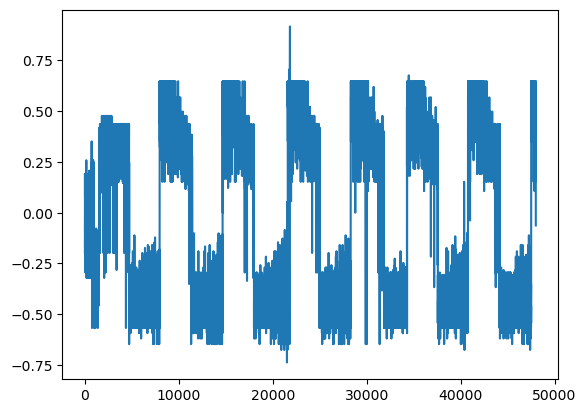

In [33]:
import matplotlib.pyplot as plt

plt.plot(seq_mu_reversed)